# Project 5 - 개선된 U-Net 모델 만들기

### 목표
- **KITTI 데이터셋 구성, Data Augmentation**
- **U-Net 및 U-Net++ 모델 구현, 모델 Training 및 Segmentation 수행**
- **U-Net, U-Net++ Segmentation 결과 사진 시각화, IoU 계산 결과 비교 및 분석**

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model, optimizers, utils, backend

In [2]:
DATA_PATH = './data/training'

### (1) KITTI 데이터셋 준비

- Augmentation

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                        width=224,
                        height=224
                        )
                    ])

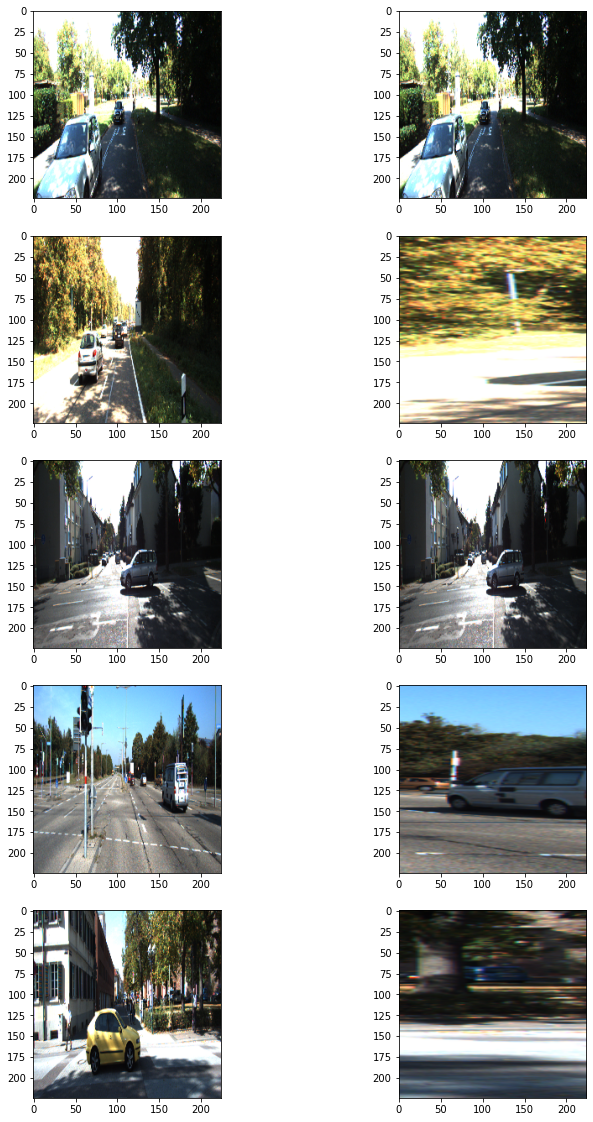

In [4]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(DATA_PATH, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

- Data Loader

In [5]:
BATCH_SIZE = 16

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train
        self.augmentation = augmentation

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8) * 1
            
            data = {"image": _input, "mask": _output}
            augmented = self.augmentation(**data)
            
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다.
        # 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            
            return self.indexes

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    DATA_PATH,
    batch_size=BATCH_SIZE,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    DATA_PATH,
    batch_size=BATCH_SIZE,
    augmentation=test_preproc,
    is_train=False
)

### (2) 모델 구현

U-Net과 U-Net++의 구조적인 차이를 보는 실험을 준비하였다.  
두 모델의 hidden layer size는 [32, 64, 128, 256, 512]로 통일하였다.

- Convolution block

In [8]:
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

- Down-sampling block

In [9]:
def down_block(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    x = conv_block(x, n_filters)
    d = layers.MaxPooling2D((2, 2))(x)

    return x, d

- Up-sampling block

In [10]:
def up_block(inputs, skip_list, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()(skip_list + [u])
    x = conv_block(x, n_filters)
    x = conv_block(x, n_filters)

    return x

- U-Net

In [11]:
def UNET(n_classes=1, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    output_size = [32, 64, 128, 256, 512]

    x00, d = down_block(inputs, output_size[0])
    
    x10, d = down_block(d, output_size[1])
    
    x20, d = down_block(d, output_size[2])
    
    x30, d = down_block(d, output_size[3])
    
    x40, _ = down_block(d, output_size[4])
    x31 = up_block(x40, [x30], output_size[3])
    x22 = up_block(x31, [x20], output_size[2])
    x13 = up_block(x22, [x10], output_size[1])
    x04 = up_block(x13, [x00], output_size[0])

    if n_classes == 1:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x04)
    else:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x04)

    return Model(inputs, x, name='U-Net')

- U-Net++

In [13]:
def UNETPP(n_classes=1, input_shape=(224, 224, 3), deep_supervision=False):
    inputs = Input(shape=input_shape)
    output_size = [32, 64, 128, 256, 512]

    x00, d = down_block(inputs, output_size[0])
    
    x10, d = down_block(d, output_size[1])
    x01 = up_block(x10, [x00], output_size[0])
    
    x20, d = down_block(d, output_size[2])
    x11 = up_block(x20, [x10], output_size[0])
    x02 = up_block(x11, [x00, x01], output_size[0])
    
    x30, d = down_block(d, output_size[3])
    x21 = up_block(x30, [x20], output_size[0])
    x12 = up_block(x21, [x10, x11], output_size[0])
    x03 = up_block(x12, [x00, x01, x02], output_size[0])
    
    x40, _ = down_block(d, output_size[4])
    x31 = up_block(x40, [x30], output_size[3])
    x22 = up_block(x31, [x20, x21], output_size[2])
    x13 = up_block(x22, [x10, x11, x12], output_size[1])
    x04 = up_block(x13, [x00, x01, x02, x03], output_size[0])

    if n_classes == 1:
        x1 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x01)
        x2 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x02)
        x3 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x03)
        x4 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x04)
    else:
        x1 = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x01)
        x2 = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x02)
        x3 = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x03)
        x4 = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x04)
    
    if deep_supervision:
        x = [x1, x2, x3, x4]
    else:
        x = [x4]

    return Model(inputs, x, name='U-NetPP-D') if deep_supervision else Model(inputs, x, name='U-NetPP')

### (3) 모델 생성

U-Net, U-Net++, U-Net++ with deep supervision으로 총 3가지 모델을 비교해보았다.

- Dice Coefficient

In [22]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

- Model Compile

In [23]:
def model_compile(model):
    with tf.device('/GPU:0'):
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=bce_dice_loss,
            metrics=["binary_crossentropy", dice_coef]
        )

        model.summary()
        
        utils.plot_model(model, show_shapes=True, show_layer_names=False, to_file=f'./model_{model.name}.png')

#### U-Net

In [24]:
model_unet = UNET()
model_compile(model_unet)

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 224, 224, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 224, 224, 32) 128         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 224, 224, 32) 0           batch_normalization_78[0][0]     
______________________________________________________________________________________________

#### U-Net++

In [25]:
model_unetpp = UNETPP()
model_compile(model_unetpp)

Model: "U-NetPP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 224, 224, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 224, 224, 32) 128         conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 224, 224, 32) 0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

#### U-Net++ with deep supervision

In [26]:
model_unetppd = UNETPP(deep_supervision=True)
model_compile(model_unetppd)

Model: "U-NetPP-D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 224, 224, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 224, 224, 32) 128         conv2d_140[0][0]                 
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 224, 224, 32) 0           batch_normalization_126[0][0]    
__________________________________________________________________________________________

### (4) 모델 학습

In [27]:
def model_train(model, batch_size=BATCH_SIZE, train_data=train_generator, val_data=test_generator):
    model_path = f'./model/seg_model_{model.name}.h5'
    
    # batch_size = 16
    history = model.fit(
        train_data,
        validation_data=val_data,
        steps_per_epoch=len(train_data),
        batch_size=batch_size,
        epochs=100,
    )
    
    model.save(model_path)  #학습한 모델을 저장해 주세요.
    
    return model_path, history

In [28]:
model_path_dict = {}
history_dict = {}

In [29]:
model_path, history = model_train(model_unet)
model_path_dict[model_unet.name] = model_path
history_dict[model_unet.name] = history

Epoch 1/100
11/11 [==============================] - 10s 689ms/step - loss: -0.1121 - binary_crossentropy: 0.5359 - dice_coef: 0.3800 - val_loss: 0.0323 - val_binary_crossentropy: 0.6964 - val_dice_coef: 0.3159
Epoch 2/100
11/11 [==============================] - 7s 596ms/step - loss: -0.2573 - binary_crossentropy: 0.4501 - dice_coef: 0.4824 - val_loss: 0.0364 - val_binary_crossentropy: 0.7151 - val_dice_coef: 0.3211
Epoch 3/100
11/11 [==============================] - 7s 606ms/step - loss: -0.3187 - binary_crossentropy: 0.4112 - dice_coef: 0.5243 - val_loss: 0.0484 - val_binary_crossentropy: 0.7530 - val_dice_coef: 0.3281
Epoch 4/100
11/11 [==============================] - 7s 606ms/step - loss: -0.4026 - binary_crossentropy: 0.3489 - dice_coef: 0.5770 - val_loss: 0.0678 - val_binary_crossentropy: 0.8101 - val_dice_coef: 0.3372
Epoch 5/100
11/11 [==============================] - 7s 600ms/step - loss: -0.4166 - binary_crossentropy: 0.3449 - dice_coef: 0.5891 - val_loss: 0.1094 - val_b

Epoch 40/100
11/11 [==============================] - 7s 607ms/step - loss: -0.6933 - binary_crossentropy: 0.1726 - dice_coef: 0.7796 - val_loss: -0.4437 - val_binary_crossentropy: 0.4548 - val_dice_coef: 0.6711
Epoch 41/100
11/11 [==============================] - 7s 597ms/step - loss: -0.6940 - binary_crossentropy: 0.1653 - dice_coef: 0.7766 - val_loss: -0.5890 - val_binary_crossentropy: 0.2841 - val_dice_coef: 0.7311
Epoch 42/100
11/11 [==============================] - 7s 599ms/step - loss: -0.7127 - binary_crossentropy: 0.1618 - dice_coef: 0.7935 - val_loss: -0.5706 - val_binary_crossentropy: 0.3080 - val_dice_coef: 0.7246
Epoch 43/100
11/11 [==============================] - 7s 587ms/step - loss: -0.6955 - binary_crossentropy: 0.1604 - dice_coef: 0.7757 - val_loss: -0.6085 - val_binary_crossentropy: 0.2653 - val_dice_coef: 0.7412
Epoch 44/100
11/11 [==============================] - 7s 600ms/step - loss: -0.6801 - binary_crossentropy: 0.1675 - dice_coef: 0.7638 - val_loss: -0.660

Epoch 79/100
11/11 [==============================] - 7s 590ms/step - loss: -0.7557 - binary_crossentropy: 0.1464 - dice_coef: 0.8289 - val_loss: -0.6826 - val_binary_crossentropy: 0.2176 - val_dice_coef: 0.7914
Epoch 80/100
11/11 [==============================] - 7s 580ms/step - loss: -0.7755 - binary_crossentropy: 0.1211 - dice_coef: 0.8361 - val_loss: -0.7299 - val_binary_crossentropy: 0.1786 - val_dice_coef: 0.8192
Epoch 81/100
11/11 [==============================] - 7s 599ms/step - loss: -0.7917 - binary_crossentropy: 0.1167 - dice_coef: 0.8500 - val_loss: -0.7046 - val_binary_crossentropy: 0.2013 - val_dice_coef: 0.8053
Epoch 82/100
11/11 [==============================] - 7s 592ms/step - loss: -0.7920 - binary_crossentropy: 0.1213 - dice_coef: 0.8527 - val_loss: -0.6937 - val_binary_crossentropy: 0.2117 - val_dice_coef: 0.7996
Epoch 83/100
11/11 [==============================] - 7s 593ms/step - loss: -0.7730 - binary_crossentropy: 0.1306 - dice_coef: 0.8383 - val_loss: -0.714

In [30]:
model_path, history = model_train(model_unetpp)
model_path_dict[model_unetpp.name] = model_path
history_dict[model_unetpp.name] = history

Epoch 1/100
11/11 [==============================] - 19s 860ms/step - loss: 0.1530 - binary_crossentropy: 1.0288 - dice_coef: 0.3614 - val_loss: 0.0382 - val_binary_crossentropy: 0.7080 - val_dice_coef: 0.3158
Epoch 2/100
11/11 [==============================] - 9s 740ms/step - loss: 0.0117 - binary_crossentropy: 0.8441 - dice_coef: 0.4104 - val_loss: 0.0476 - val_binary_crossentropy: 0.7499 - val_dice_coef: 0.3274
Epoch 3/100
11/11 [==============================] - 8s 735ms/step - loss: -0.0872 - binary_crossentropy: 0.7312 - dice_coef: 0.4529 - val_loss: 0.0770 - val_binary_crossentropy: 0.8378 - val_dice_coef: 0.3419
Epoch 4/100
11/11 [==============================] - 8s 733ms/step - loss: -0.2241 - binary_crossentropy: 0.5923 - dice_coef: 0.5203 - val_loss: 0.1245 - val_binary_crossentropy: 0.9749 - val_dice_coef: 0.3630
Epoch 5/100
11/11 [==============================] - 8s 730ms/step - loss: -0.2920 - binary_crossentropy: 0.5275 - dice_coef: 0.5557 - val_loss: 0.1550 - val_bin

Epoch 40/100
11/11 [==============================] - 8s 730ms/step - loss: -0.5606 - binary_crossentropy: 0.2485 - dice_coef: 0.6848 - val_loss: -0.4166 - val_binary_crossentropy: 0.4320 - val_dice_coef: 0.6326
Epoch 41/100
11/11 [==============================] - 8s 731ms/step - loss: -0.5322 - binary_crossentropy: 0.2681 - dice_coef: 0.6662 - val_loss: -0.4717 - val_binary_crossentropy: 0.3571 - val_dice_coef: 0.6502
Epoch 42/100
11/11 [==============================] - 8s 726ms/step - loss: -0.5604 - binary_crossentropy: 0.2369 - dice_coef: 0.6788 - val_loss: -0.4922 - val_binary_crossentropy: 0.3394 - val_dice_coef: 0.6619
Epoch 43/100
11/11 [==============================] - 8s 729ms/step - loss: -0.5468 - binary_crossentropy: 0.2485 - dice_coef: 0.6711 - val_loss: -0.4552 - val_binary_crossentropy: 0.4393 - val_dice_coef: 0.6749
Epoch 44/100
11/11 [==============================] - 8s 731ms/step - loss: -0.5861 - binary_crossentropy: 0.2231 - dice_coef: 0.6976 - val_loss: -0.499

Epoch 79/100
11/11 [==============================] - 8s 729ms/step - loss: -0.6459 - binary_crossentropy: 0.1974 - dice_coef: 0.7446 - val_loss: -0.6023 - val_binary_crossentropy: 0.2596 - val_dice_coef: 0.7321
Epoch 80/100
11/11 [==============================] - 8s 729ms/step - loss: -0.6759 - binary_crossentropy: 0.1623 - dice_coef: 0.7570 - val_loss: -0.6203 - val_binary_crossentropy: 0.2193 - val_dice_coef: 0.7299
Epoch 81/100
11/11 [==============================] - 8s 725ms/step - loss: -0.6786 - binary_crossentropy: 0.1623 - dice_coef: 0.7598 - val_loss: -0.5723 - val_binary_crossentropy: 0.2606 - val_dice_coef: 0.7026
Epoch 82/100
11/11 [==============================] - 8s 730ms/step - loss: -0.6692 - binary_crossentropy: 0.1712 - dice_coef: 0.7548 - val_loss: -0.6047 - val_binary_crossentropy: 0.2415 - val_dice_coef: 0.7255
Epoch 83/100
11/11 [==============================] - 9s 744ms/step - loss: -0.6760 - binary_crossentropy: 0.1680 - dice_coef: 0.7600 - val_loss: -0.545

In [31]:
model_path, history = model_train(model_unetppd)
model_path_dict[model_unetppd.name] = model_path
history_dict[model_unetppd.name] = history

Epoch 1/100
11/11 [==============================] - 15s 902ms/step - loss: 0.1016 - conv2d_170_loss: 0.0537 - conv2d_171_loss: -0.0259 - conv2d_172_loss: 0.0067 - conv2d_173_loss: 0.0671 - conv2d_170_binary_crossentropy: 0.7537 - conv2d_170_dice_coef: 0.3231 - conv2d_171_binary_crossentropy: 0.5830 - conv2d_171_dice_coef: 0.3174 - conv2d_172_binary_crossentropy: 0.7430 - conv2d_172_dice_coef: 0.3648 - conv2d_173_binary_crossentropy: 0.8830 - conv2d_173_dice_coef: 0.3745 - val_loss: 0.1305 - val_conv2d_170_loss: 0.0341 - val_conv2d_171_loss: 0.0270 - val_conv2d_172_loss: 0.0340 - val_conv2d_173_loss: 0.0354 - val_conv2d_170_binary_crossentropy: 0.6986 - val_conv2d_170_dice_coef: 0.3151 - val_conv2d_171_binary_crossentropy: 0.6817 - val_conv2d_171_dice_coef: 0.3139 - val_conv2d_172_binary_crossentropy: 0.6992 - val_conv2d_172_dice_coef: 0.3156 - val_conv2d_173_binary_crossentropy: 0.7059 - val_conv2d_173_dice_coef: 0.3175
Epoch 2/100
11/11 [==============================] - 9s 757ms/ste

Epoch 10/100
11/11 [==============================] - 9s 740ms/step - loss: -1.7845 - conv2d_170_loss: -0.3299 - conv2d_171_loss: -0.4856 - conv2d_172_loss: -0.4737 - conv2d_173_loss: -0.4953 - conv2d_170_binary_crossentropy: 0.4506 - conv2d_170_dice_coef: 0.5552 - conv2d_171_binary_crossentropy: 0.3108 - conv2d_171_dice_coef: 0.6410 - conv2d_172_binary_crossentropy: 0.3503 - conv2d_172_dice_coef: 0.6488 - conv2d_173_binary_crossentropy: 0.3301 - conv2d_173_dice_coef: 0.6604 - val_loss: 4.0996 - val_conv2d_170_loss: 0.3758 - val_conv2d_171_loss: 0.4375 - val_conv2d_172_loss: 1.3457 - val_conv2d_173_loss: 1.9406 - val_conv2d_170_binary_crossentropy: 1.5026 - val_conv2d_170_dice_coef: 0.3755 - val_conv2d_171_binary_crossentropy: 1.6174 - val_conv2d_171_dice_coef: 0.3712 - val_conv2d_172_binary_crossentropy: 3.4410 - val_conv2d_172_dice_coef: 0.3748 - val_conv2d_173_binary_crossentropy: 4.6497 - val_conv2d_173_dice_coef: 0.3843
Epoch 11/100
11/11 [==============================] - 9s 743m

Epoch 19/100
11/11 [==============================] - 9s 744ms/step - loss: -2.1461 - conv2d_170_loss: -0.4174 - conv2d_171_loss: -0.5839 - conv2d_172_loss: -0.5782 - conv2d_173_loss: -0.5666 - conv2d_170_binary_crossentropy: 0.3775 - conv2d_170_dice_coef: 0.6062 - conv2d_171_binary_crossentropy: 0.2597 - conv2d_171_dice_coef: 0.7138 - conv2d_172_binary_crossentropy: 0.2730 - conv2d_172_dice_coef: 0.7147 - conv2d_173_binary_crossentropy: 0.2752 - conv2d_173_dice_coef: 0.7042 - val_loss: 6.3907 - val_conv2d_170_loss: 1.0269 - val_conv2d_171_loss: 1.1933 - val_conv2d_172_loss: 1.7177 - val_conv2d_173_loss: 2.4527 - val_conv2d_170_binary_crossentropy: 2.8134 - val_conv2d_170_dice_coef: 0.3798 - val_conv2d_171_binary_crossentropy: 3.1443 - val_conv2d_171_dice_coef: 0.3788 - val_conv2d_172_binary_crossentropy: 4.1894 - val_conv2d_172_dice_coef: 0.3770 - val_conv2d_173_binary_crossentropy: 5.6643 - val_conv2d_173_dice_coef: 0.3794
Epoch 20/100
11/11 [==============================] - 8s 743m

Epoch 28/100
11/11 [==============================] - 9s 744ms/step - loss: -2.3112 - conv2d_170_loss: -0.4530 - conv2d_171_loss: -0.6215 - conv2d_172_loss: -0.6273 - conv2d_173_loss: -0.6095 - conv2d_170_binary_crossentropy: 0.3610 - conv2d_170_dice_coef: 0.6335 - conv2d_171_binary_crossentropy: 0.2361 - conv2d_171_dice_coef: 0.7395 - conv2d_172_binary_crossentropy: 0.2292 - conv2d_172_dice_coef: 0.7419 - conv2d_173_binary_crossentropy: 0.2253 - conv2d_173_dice_coef: 0.7221 - val_loss: 2.9321 - val_conv2d_170_loss: 0.7576 - val_conv2d_171_loss: 0.4445 - val_conv2d_172_loss: 0.9090 - val_conv2d_173_loss: 0.8211 - val_conv2d_170_binary_crossentropy: 2.3199 - val_conv2d_170_dice_coef: 0.4024 - val_conv2d_171_binary_crossentropy: 1.7520 - val_conv2d_171_dice_coef: 0.4315 - val_conv2d_172_binary_crossentropy: 2.6318 - val_conv2d_172_dice_coef: 0.4069 - val_conv2d_173_binary_crossentropy: 2.5066 - val_conv2d_173_dice_coef: 0.4322
Epoch 29/100
11/11 [==============================] - 9s 743m

Epoch 37/100
11/11 [==============================] - 9s 748ms/step - loss: -2.3697 - conv2d_170_loss: -0.4679 - conv2d_171_loss: -0.6282 - conv2d_172_loss: -0.6436 - conv2d_173_loss: -0.6299 - conv2d_170_binary_crossentropy: 0.3530 - conv2d_170_dice_coef: 0.6444 - conv2d_171_binary_crossentropy: 0.2353 - conv2d_171_dice_coef: 0.7459 - conv2d_172_binary_crossentropy: 0.2084 - conv2d_172_dice_coef: 0.7479 - conv2d_173_binary_crossentropy: 0.2055 - conv2d_173_dice_coef: 0.7327 - val_loss: 0.5034 - val_conv2d_170_loss: 0.2061 - val_conv2d_171_loss: 0.0547 - val_conv2d_172_loss: 0.1975 - val_conv2d_173_loss: 0.0450 - val_conv2d_170_binary_crossentropy: 1.4225 - val_conv2d_170_dice_coef: 0.5051 - val_conv2d_171_binary_crossentropy: 1.2328 - val_conv2d_171_dice_coef: 0.5616 - val_conv2d_172_binary_crossentropy: 1.5015 - val_conv2d_172_dice_coef: 0.5533 - val_conv2d_173_binary_crossentropy: 1.2528 - val_conv2d_173_dice_coef: 0.5814
Epoch 38/100
11/11 [==============================] - 9s 743m

Epoch 46/100
11/11 [==============================] - 9s 749ms/step - loss: -2.6015 - conv2d_170_loss: -0.5328 - conv2d_171_loss: -0.6837 - conv2d_172_loss: -0.6990 - conv2d_173_loss: -0.6859 - conv2d_170_binary_crossentropy: 0.3004 - conv2d_170_dice_coef: 0.6830 - conv2d_171_binary_crossentropy: 0.1976 - conv2d_171_dice_coef: 0.7825 - conv2d_172_binary_crossentropy: 0.1827 - conv2d_172_dice_coef: 0.7903 - conv2d_173_binary_crossentropy: 0.1777 - conv2d_173_dice_coef: 0.7748 - val_loss: -2.1218 - val_conv2d_170_loss: -0.3520 - val_conv2d_171_loss: -0.5586 - val_conv2d_172_loss: -0.5946 - val_conv2d_173_loss: -0.6166 - val_conv2d_170_binary_crossentropy: 0.5378 - val_conv2d_170_dice_coef: 0.6209 - val_conv2d_171_binary_crossentropy: 0.2989 - val_conv2d_171_dice_coef: 0.7081 - val_conv2d_172_binary_crossentropy: 0.2819 - val_conv2d_172_dice_coef: 0.7356 - val_conv2d_173_binary_crossentropy: 0.2514 - val_conv2d_173_dice_coef: 0.7423
Epoch 47/100
11/11 [==============================] - 9s

Epoch 55/100
11/11 [==============================] - 8s 740ms/step - loss: -2.7507 - conv2d_170_loss: -0.5703 - conv2d_171_loss: -0.7145 - conv2d_172_loss: -0.7393 - conv2d_173_loss: -0.7266 - conv2d_170_binary_crossentropy: 0.2744 - conv2d_170_dice_coef: 0.7075 - conv2d_171_binary_crossentropy: 0.1816 - conv2d_171_dice_coef: 0.8053 - conv2d_172_binary_crossentropy: 0.1492 - conv2d_172_dice_coef: 0.8139 - conv2d_173_binary_crossentropy: 0.1466 - conv2d_173_dice_coef: 0.7999 - val_loss: -2.3113 - val_conv2d_170_loss: -0.4899 - val_conv2d_171_loss: -0.5932 - val_conv2d_172_loss: -0.6093 - val_conv2d_173_loss: -0.6189 - val_conv2d_170_binary_crossentropy: 0.3540 - val_conv2d_170_dice_coef: 0.6669 - val_conv2d_171_binary_crossentropy: 0.2957 - val_conv2d_171_dice_coef: 0.7411 - val_conv2d_172_binary_crossentropy: 0.2725 - val_conv2d_172_dice_coef: 0.7456 - val_conv2d_173_binary_crossentropy: 0.2347 - val_conv2d_173_dice_coef: 0.7362
Epoch 56/100
11/11 [==============================] - 8s

Epoch 64/100
11/11 [==============================] - 9s 742ms/step - loss: -2.7516 - conv2d_170_loss: -0.5682 - conv2d_171_loss: -0.7133 - conv2d_172_loss: -0.7399 - conv2d_173_loss: -0.7301 - conv2d_170_binary_crossentropy: 0.2744 - conv2d_170_dice_coef: 0.7054 - conv2d_171_binary_crossentropy: 0.1820 - conv2d_171_dice_coef: 0.8043 - conv2d_172_binary_crossentropy: 0.1522 - conv2d_172_dice_coef: 0.8161 - conv2d_173_binary_crossentropy: 0.1442 - conv2d_173_dice_coef: 0.8022 - val_loss: -2.3239 - val_conv2d_170_loss: -0.5123 - val_conv2d_171_loss: -0.5882 - val_conv2d_172_loss: -0.6373 - val_conv2d_173_loss: -0.5861 - val_conv2d_170_binary_crossentropy: 0.3153 - val_conv2d_170_dice_coef: 0.6700 - val_conv2d_171_binary_crossentropy: 0.2860 - val_conv2d_171_dice_coef: 0.7312 - val_conv2d_172_binary_crossentropy: 0.2335 - val_conv2d_172_dice_coef: 0.7541 - val_conv2d_173_binary_crossentropy: 0.2273 - val_conv2d_173_dice_coef: 0.6998
Epoch 65/100
11/11 [==============================] - 9s

Epoch 73/100
11/11 [==============================] - 9s 742ms/step - loss: -2.6615 - conv2d_170_loss: -0.5553 - conv2d_171_loss: -0.6870 - conv2d_172_loss: -0.7067 - conv2d_173_loss: -0.7125 - conv2d_170_binary_crossentropy: 0.2875 - conv2d_170_dice_coef: 0.6991 - conv2d_171_binary_crossentropy: 0.2109 - conv2d_171_dice_coef: 0.7925 - conv2d_172_binary_crossentropy: 0.1936 - conv2d_172_dice_coef: 0.8035 - conv2d_173_binary_crossentropy: 0.1601 - conv2d_173_dice_coef: 0.7925 - val_loss: -2.2776 - val_conv2d_170_loss: -0.5121 - val_conv2d_171_loss: -0.5865 - val_conv2d_172_loss: -0.5535 - val_conv2d_173_loss: -0.6254 - val_conv2d_170_binary_crossentropy: 0.3042 - val_conv2d_170_dice_coef: 0.6642 - val_conv2d_171_binary_crossentropy: 0.3006 - val_conv2d_171_dice_coef: 0.7368 - val_conv2d_172_binary_crossentropy: 0.2986 - val_conv2d_172_dice_coef: 0.7029 - val_conv2d_173_binary_crossentropy: 0.2333 - val_conv2d_173_dice_coef: 0.7421
Epoch 74/100
11/11 [==============================] - 9s

Epoch 82/100
11/11 [==============================] - 9s 743ms/step - loss: -2.8349 - conv2d_170_loss: -0.5939 - conv2d_171_loss: -0.7289 - conv2d_172_loss: -0.7562 - conv2d_173_loss: -0.7559 - conv2d_170_binary_crossentropy: 0.2617 - conv2d_170_dice_coef: 0.7247 - conv2d_171_binary_crossentropy: 0.1752 - conv2d_171_dice_coef: 0.8165 - conv2d_172_binary_crossentropy: 0.1431 - conv2d_172_dice_coef: 0.8277 - conv2d_173_binary_crossentropy: 0.1323 - conv2d_173_dice_coef: 0.8220 - val_loss: -2.4415 - val_conv2d_170_loss: -0.5644 - val_conv2d_171_loss: -0.6295 - val_conv2d_172_loss: -0.6374 - val_conv2d_173_loss: -0.6101 - val_conv2d_170_binary_crossentropy: 0.2797 - val_conv2d_170_dice_coef: 0.7043 - val_conv2d_171_binary_crossentropy: 0.2661 - val_conv2d_171_dice_coef: 0.7625 - val_conv2d_172_binary_crossentropy: 0.2438 - val_conv2d_172_dice_coef: 0.7593 - val_conv2d_173_binary_crossentropy: 0.2457 - val_conv2d_173_dice_coef: 0.7330
Epoch 83/100
11/11 [==============================] - 9s

Epoch 91/100
11/11 [==============================] - 9s 743ms/step - loss: -2.9226 - conv2d_170_loss: -0.6303 - conv2d_171_loss: -0.7528 - conv2d_172_loss: -0.7742 - conv2d_173_loss: -0.7652 - conv2d_170_binary_crossentropy: 0.2257 - conv2d_170_dice_coef: 0.7432 - conv2d_171_binary_crossentropy: 0.1590 - conv2d_171_dice_coef: 0.8324 - conv2d_172_binary_crossentropy: 0.1373 - conv2d_172_dice_coef: 0.8429 - conv2d_173_binary_crossentropy: 0.1293 - conv2d_173_dice_coef: 0.8299 - val_loss: -2.7234 - val_conv2d_170_loss: -0.5980 - val_conv2d_171_loss: -0.6842 - val_conv2d_172_loss: -0.7219 - val_conv2d_173_loss: -0.7192 - val_conv2d_170_binary_crossentropy: 0.2529 - val_conv2d_170_dice_coef: 0.7245 - val_conv2d_171_binary_crossentropy: 0.2413 - val_conv2d_171_dice_coef: 0.8049 - val_conv2d_172_binary_crossentropy: 0.1857 - val_conv2d_172_dice_coef: 0.8148 - val_conv2d_173_binary_crossentropy: 0.1764 - val_conv2d_173_dice_coef: 0.8074
Epoch 92/100
11/11 [==============================] - 9s

Epoch 100/100
11/11 [==============================] - 9s 740ms/step - loss: -2.9008 - conv2d_170_loss: -0.6120 - conv2d_171_loss: -0.7392 - conv2d_172_loss: -0.7783 - conv2d_173_loss: -0.7713 - conv2d_170_binary_crossentropy: 0.2448 - conv2d_170_dice_coef: 0.7345 - conv2d_171_binary_crossentropy: 0.1713 - conv2d_171_dice_coef: 0.8248 - conv2d_172_binary_crossentropy: 0.1280 - conv2d_172_dice_coef: 0.8423 - conv2d_173_binary_crossentropy: 0.1178 - conv2d_173_dice_coef: 0.8302 - val_loss: -2.6471 - val_conv2d_170_loss: -0.5945 - val_conv2d_171_loss: -0.6555 - val_conv2d_172_loss: -0.6960 - val_conv2d_173_loss: -0.7011 - val_conv2d_170_binary_crossentropy: 0.2713 - val_conv2d_170_dice_coef: 0.7301 - val_conv2d_171_binary_crossentropy: 0.2617 - val_conv2d_171_dice_coef: 0.7864 - val_conv2d_172_binary_crossentropy: 0.2272 - val_conv2d_172_dice_coef: 0.8096 - val_conv2d_173_binary_crossentropy: 0.2292 - val_conv2d_173_dice_coef: 0.8157


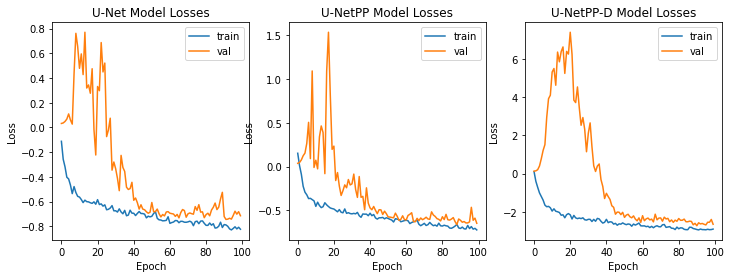

In [99]:
plt.figure(figsize=(12, 4))

# train, validation loss graph
plt.subplot(1, 3, 1)
plt.plot(history_dict[model_unet.name].history['loss'])
plt.plot(history_dict[model_unet.name].history['val_loss'])
plt.title(f'{model_unet.name} Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history_dict[model_unetpp.name].history['loss'])
plt.plot(history_dict[model_unetpp.name].history['val_loss'])
plt.title(f'{model_unetpp.name} Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history_dict[model_unetppd.name].history['loss'])
plt.plot(history_dict[model_unetppd.name].history['val_loss'])
plt.title(f'{model_unetppd.name} Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

### (5) 모델 평가

In [100]:
def get_output(model, preproc, image_path, output_path, label_path, subplot_num, is_imshow=True):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255 # threshold에 따라 결과 달라짐
    prediction = output/255   # 도로로 판단한 영역
    
    if np.ndim(output) > 2:
        output = output[0]
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    if is_imshow:
        plt.subplot(1, 3, subplot_num)
        plt.imshow(output)
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, target, prediction
    else:
        return output, _, prediction

In [103]:
def calculate_iou_score(model_name, target, prediction, is_print=True):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = tf.cast(np.sum(intersection) / np.sum(union), tf.float32)
    
    if is_print:
        print(f'{model_name} IoU : {iou_score:.4f}', end='\t\t   ')
    
    return iou_score

U-Net IoU : 0.7149		   U-NetPP IoU : 0.7769		   U-NetPP-D IoU : 0.7801		   

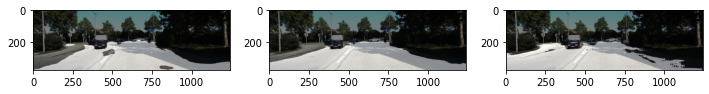


U-Net IoU : 0.6912		   U-NetPP IoU : 0.8023		   U-NetPP-D IoU : 0.7241		   

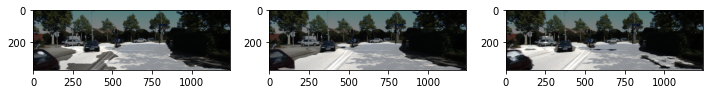


U-Net IoU : 0.7149		   U-NetPP IoU : 0.7697		   U-NetPP-D IoU : 0.7559		   

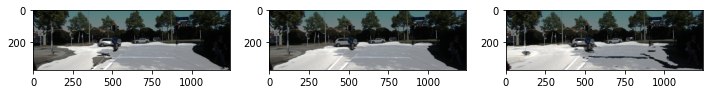


U-Net IoU : 0.6616		   U-NetPP IoU : 0.7115		   U-NetPP-D IoU : 0.7263		   

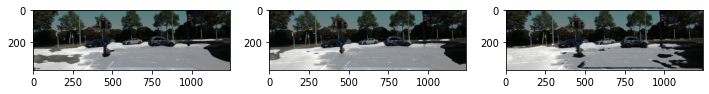

In [104]:
for i in range(7, 11):    # i값을 바꾸면 테스트용 파일이 달라집니다. 
    image_path = DATA_PATH + f'/image_2/00{str(i).zfill(4)}_10.png'
    output_path = DATA_PATH + f'/result/result_{str(i).zfill(3)}.png'
    label_path = DATA_PATH + f'/semantic/00{str(i).zfill(4)}_10.png'
    
    plt.figure(figsize=(12, 5))
    
    for j, m in enumerate([model_unet, model_unetpp, model_unetppd]):
        output, target, prediction = get_output(m, test_preproc, image_path, output_path, label_path, j+1)
        calculate_iou_score(m.name, target, prediction)
    
    plt.show()
    print()

- Dataset 총 평균

In [105]:
iou_score_dict = {model_unet.name:[], model_unetpp.name:[], model_unetppd.name:[]}

for i in range(200):    # i값을 바꾸면 테스트용 파일이 달라집니다. 
    image_path = DATA_PATH + f'/image_2/00{str(i).zfill(4)}_10.png'
    output_path = DATA_PATH + f'/result/result_{str(i).zfill(3)}.png'
    label_path = DATA_PATH + f'/semantic/00{str(i).zfill(4)}_10.png'
    
    for j, m in enumerate([model_unet, model_unetpp, model_unetppd]):
        output, target, prediction = get_output(m, test_preproc, image_path, output_path, label_path, j+1, False)
        iou_score = calculate_iou_score(m.name, target, prediction, False)
        iou_score_dict[m.name].append(iou_score)

In [106]:
print(model_unet.name, ":", sum(iou_score_dict[model_unet.name]) / len(iou_score_dict[model_unet.name]))
print(model_unetpp.name, ":", sum(iou_score_dict[model_unetpp.name]) / len(iou_score_dict[model_unetpp.name]))
print(model_unetppd.name, ":", sum(iou_score_dict[model_unetppd.name]) / len(iou_score_dict[model_unetppd.name]))

U-Net : tf.Tensor(0.8246968, shape=(), dtype=float32)
U-NetPP : tf.Tensor(0.8252617, shape=(), dtype=float32)
U-NetPP-D : tf.Tensor(0.73096585, shape=(), dtype=float32)


### (6) 분석

- 먼저, dice coefficient라는 loss가 인상깊었다.
- loss의 그래프가 수렴은 하는데 음수의 값으로 수렴을 하였다.
- binary cross entropy에 조화평균을 더하는 형태였는데 그래프가 저렇게 나오는 것이 신기했다.

- IoU의 경우, U-Net의 결과가 좋을 때도 있고 U-Net++의 결과가 좋을 때도 있었다.
- U-Net++ with deep supervision의 경우에는 결과를 어떻게 해석해야 할지 잘 모르겠다.
- 전체 IoU의 평균은 U-Net++가 U-Net보다 살짝 높았지만 오차 수준이어서 해석하기 어려울 것 같다.

### (7) 회고

논문에서는 U-Net++의 성능이 U-Net보다 3% 정도 높게 나타났다.  
이는 유의미한 차이라고 볼 수 있다.  
직접 구현한 U-Net++에는 큰 문제가 있지 않다고 생각한다.  
그렇지만 결과가 U-Net과 비슷하게 나온 이유는 아무래도 dataset이 너무 적거나 epoch 수의 문제일 것 같다.